In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

In [2]:
base_path = Path.cwd().parent / 'data' / 'base'
data_path = Path.cwd().parent / 'data' / 'prerun'

bmus = pd.read_csv(data_path / 'prepared_bmus.csv', index_col=0)
bmus = bmus.loc[bmus.carrier.str.contains('wind')]

In [4]:
# month = '2022-12'

month = '2022, 2023, 2024'

# Get all days in the month
# days = pd.date_range(start=month + '-01', end=month + '-31', freq='D')
# days = [day.strftime('%Y-%m-%d') for day in days]

days = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D').strftime('%Y-%m-%d')

# Initialize lists to store data for each day
physical_notifications_list = []
offers_list = []
day_ahead_prices_list = []

# Loop through each day and collect the data
for day in tqdm(days):
    day_path = base_path / day
    
    # Physical notifications
    pn_path = day_path / 'physical_notifications.csv'
    if pn_path.exists():
        pn_df = pd.read_csv(pn_path, index_col=0, parse_dates=True)
        physical_notifications_list.append(pn_df)

    # Offers
    offers_path = day_path / 'offers.csv'
    if offers_path.exists():
        offers_df = pd.read_csv(offers_path, index_col=[0,1], parse_dates=True)
        offers_list.append(offers_df)
    
    # Day-ahead prices
    dap_path = day_path / 'day_ahead_prices.csv'
    if dap_path.exists():
        dap_df = pd.read_csv(dap_path, index_col=0, parse_dates=True)
        day_ahead_prices_list.append(dap_df)

# Concatenate all the data at once
physical_notifications = pd.concat(physical_notifications_list) if physical_notifications_list else pd.DataFrame()
offers = pd.concat(offers_list) if offers_list else pd.DataFrame()
day_ahead_prices = pd.concat(day_ahead_prices_list) if day_ahead_prices_list else pd.DataFrame()

print(f"Loaded data for {month}:")
print(f"Physical notifications: {len(physical_notifications)} rows")
print(f"Offers: {len(offers)} rows")
print(f"Day-ahead prices: {len(day_ahead_prices)} rows")

  0%|          | 0/1096 [00:00<?, ?it/s]C:\Users\lukas\AppData\Local\Temp\ipykernel_34108\2484786866.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  offers_df = pd.read_csv(offers_path, index_col=[0,1], parse_dates=True)
C:\Users\lukas\AppData\Local\Temp\ipykernel_34108\2484786866.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  offers_df = pd.read_csv(offers_path, index_col=[0,1], parse_dates=True)
  0%|          | 2/1096 [00:00<01:05, 16.69it/s]C:\Users\lukas\AppData\Local\Temp\ipykernel_34108\2484786866.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  offers

Loaded data for 2022, 2023, 2024:
Physical notifications: 52608 rows
Offers: 105120 rows
Day-ahead prices: 52560 rows


In [5]:
idx = pd.IndexSlice

vols_offers = offers.loc[idx[:, 'vol'], :]
prices_offers = offers.loc[idx[:, 'price'], :]

vols_offers.index = vols_offers.index.droplevel(1)
prices_offers.index = prices_offers.index.droplevel(1)

sorting = vols_offers.sum(axis=1).sort_values(ascending=False)

prices_offers = prices_offers.loc[sorting.index]
vols_offers = vols_offers.loc[sorting.index].mul(2) # now expressed in power not energy

In [6]:
# Get statistics for all weeks in 2022, 2023, and 2024
import os
from pathlib import Path

# Create a list to store dataframes for each week
smc_list = []

# Years to process
years = [2022, 2023, 2024]

# Process all weekly files for the specified years
for year in years:
    year_str = str(year)
    thermal_costs_dir = data_path / 'thermal_costs'
    
    # Get all files for this year
    if thermal_costs_dir.exists():
        for file in thermal_costs_dir.glob(f"{year_str}-week*.csv"):
            try:
                # Extract week number from filename
                week_str = file.stem.split('-week')[1]
                week_data = pd.read_csv(file, index_col=0).rename(columns={'0': f'{year_str}-week{week_str}'})
                smc_list.append(week_data)
            except Exception as e:
                print(f"Warning: Error processing file {file}: {e}")
    else:
        print(f"Warning: Directory {thermal_costs_dir} not found")

# Concatenate all weekly data horizontally
smc = pd.concat(smc_list, axis=1) if smc_list else pd.DataFrame()
print(f"Loaded {len(smc.columns)} weeks of thermal cost data from 2022-2024")

Loaded 156 weeks of thermal cost data from 2022-2024


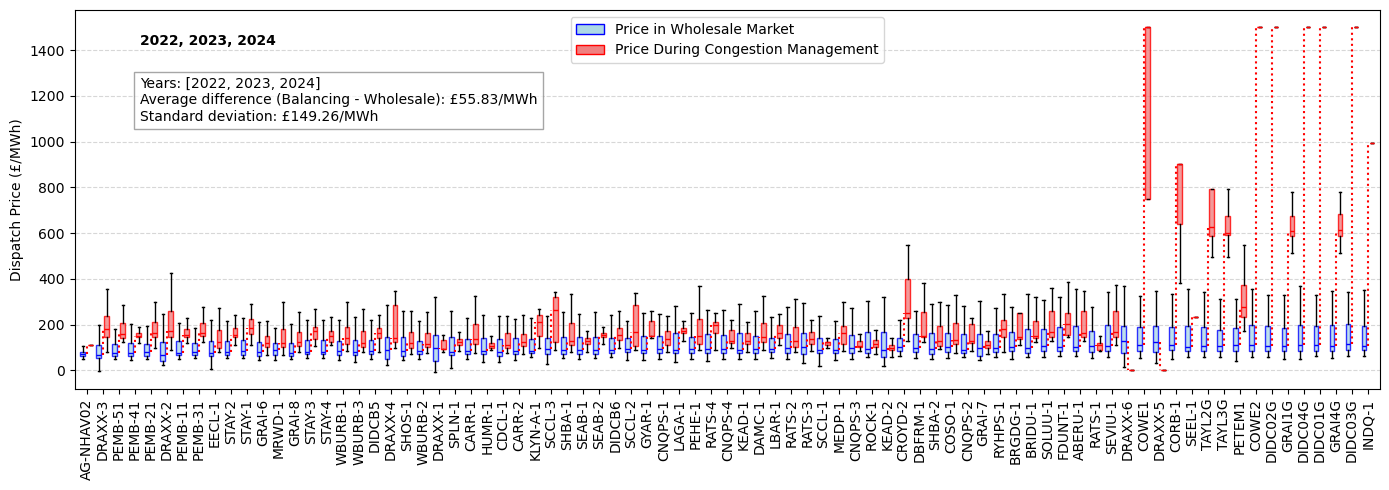

In [11]:
# Create a figure and axis for the boxplots
fig, ax = plt.subplots(figsize=(14, 5))

# Lists to store x positions and labels for the x-axis
x_positions = []
x_labels = []

# Counter for x position
x_pos = 1

# Define colors for wholesale and balancing
wholesale_color = 'lightblue'
balancing_color = 'lightcoral'

# Calculate mean SMC for each generator and sort
smc_means = smc.mean(axis=1).dropna()
sorted_generators = smc_means.sort_values().index

# Lists to store differences for statistics
price_differences = []

# Iterate over the sorted generators
for entry in sorted_generators:
    # Skip if the entry is not in the columns of prices_offers
    if entry not in prices_offers.columns:
        continue
    
    # Get the SMC values for this generator
    smc_values = smc.loc[entry].dropna().values
    
    # Get the price offers for this generator
    price_values = prices_offers[entry].dropna().values
    
    # Calculate differences for statistics
    for s, p in zip(smc_values, price_values):
        if not np.isnan(s) and not np.isnan(p):
            price_differences.append(p - s)
    
    # Create boxplots at the same x position without fliers (showfliers=False)
    bp1 = ax.boxplot([smc_values], positions=[x_pos - 0.25], widths=0.3, patch_artist=True, 
                     boxprops=dict(alpha=0.8, color='blue', facecolor=wholesale_color), 
                     medianprops=dict(color='blue'),
                     showfliers=False)
    
    bp2 = ax.boxplot([price_values], positions=[x_pos + 0.25], widths=0.3, patch_artist=True,
                     boxprops=dict(alpha=0.8, color='red', facecolor=balancing_color),
                     medianprops=dict(color='red'),
                     showfliers=False)
    
    # Calculate means for both datasets
    smc_mean = np.median(smc_values)
    price_mean = np.median(price_values)
    
    # Draw vertical dotted red line between the means
    ax.plot([x_pos, x_pos], [smc_mean, price_mean], 'r:', linewidth=1.5)
    
    # Store the x position and label
    x_positions.append(x_pos)
    x_labels.append(entry)
    
    # Increment x position
    x_pos += 1

# Calculate and display statistics for price differences
avg_difference = np.mean(price_differences)
std_difference = np.std(price_differences)
stats_text = f"Years: {years}\nAverage difference (Balancing - Wholesale): £{avg_difference:.2f}/MWh\nStandard deviation: £{std_difference:.2f}/MWh"
ax.text(0.05, 0.70, stats_text, transform=ax.transAxes, ha='left', va='bottom', fontsize=10, 
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

# Set the x-axis labels with rotation
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=90)

# Add a legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=wholesale_color, edgecolor='blue', label='Price in Wholesale Market'),
    Patch(facecolor=balancing_color, edgecolor='red', label='Price During Congestion Management')
]
ax.legend(handles=legend_elements, loc='upper center')

# Set labels and title
ax.set_ylabel('Dispatch Price (£/MWh)')
ax.text(0.05, 0.90, f'{month}', transform=ax.transAxes, ha='left', va='bottom', fontweight='bold')
# ax.set_title('Short Marginal Costs vs Offer Prices by Generator (Sorted by Mean SMC)')
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_axisbelow(True)

# Adjust layout to make room for rotated labels
# plt.savefig(f'compare_wholesale_balancing_{month}.pdf', bbox_inches='tight')
plt.savefig(f'compare_wholesale_balancing_three_years.pdf', bbox_inches='tight')
plt.tight_layout()


In [34]:
day_ahead_prices

,day-ahead-prices
2025-03-01 00:00:00+00:00,95.53
2025-03-01 00:30:00+00:00,101.96
2025-03-01 01:00:00+00:00,94.88
2025-03-01 01:30:00+00:00,88.04
2025-03-01 02:00:00+00:00,88.44
...,...
2025-03-26 21:30:00+00:00,96.92
2025-03-26 22:00:00+00:00,94.43
2025-03-26 22:30:00+00:00,93.20
2025-03-26 23:00:00+00:00,79.70
